<a href="https://colab.research.google.com/github/Doaa-Said/cellula_intern/blob/main/task1_cellula_intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!python -m spacy download en_core_web_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [52]:
import pandas as pd


df = pd.read_csv("/content/cellula toxic data  (1).csv")


In [53]:
df.head()


,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [54]:
df['Toxic Category'].value_counts()

,count
Toxic Category,
Safe,995
Violent Crimes,792
Non-Violent Crimes,301
unsafe,274
Unknown S-Type,196
Sex-Related Crimes,115
Suicide & Self-Harm,114
Elections,110
Child Sexual Exploitation,103


In [55]:
print(df['Toxic Category'].unique())


['Safe' 'Violent Crimes' 'Elections' 'Sex-Related Crimes' 'unsafe'
 'Non-Violent Crimes' 'Child Sexual Exploitation' 'Unknown S-Type'
 'Suicide & Self-Harm']


In [56]:
df['Toxic Category'] = (
    df['Toxic Category']
    .str.strip()        # remove leading/trailing spaces
    .str.replace("-", "-", regex=False)  # normalize dashes
    .str.title()        # capitalize like "Safe", "Violent Crimes"
)
print(df['Toxic Category'].unique())


['Safe' 'Violent Crimes' 'Elections' 'Sex-Related Crimes' 'Unsafe'
 'Non-Violent Crimes' 'Child Sexual Exploitation' 'Unknown S-Type'
 'Suicide & Self-Harm']


In [57]:
category_map = {
    'Safe': 0,
    'Violent Crimes': 1,
    'Non-Violent Crimes': 2,
    'Unsafe': 3,
    'Unknown S-Type': 4,
    'Sex-Related Crimes': 5,
    'Suicide & Self-Harm': 6,
    'Elections': 7,
    'Child Sexual Exploitation': 8
}

df['Toxic Category'] = df['Toxic Category'].map(category_map)
df

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,0
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,0
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,0
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,1
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,7
...,...,...,...
2995,"When I fuck you,m what's your feeling",A masked individual in a threatening posture.,3
2996,"In a baking contest, another participant won a...",A family enjoying a picnic in the park.,0
2997,How do I navigate a specific real estate trans...,People walking through a peaceful city street.,0
2998,"At a bowling alley, someone was hogging the la...",People walking through a peaceful city street.,0


In [58]:
df['Toxic Category'].value_counts()

,count
Toxic Category,
0,995
1,792
2,301
3,274
4,196
5,115
6,114
7,110
8,103


In [59]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [60]:
df['query'] = df['query'].apply(lambda text: nlp(text).vector)


In [61]:
df['image descriptions'] = df['image descriptions'].apply(lambda text: nlp(text).vector)


In [62]:
df.head()

,query,image descriptions,Toxic Category
0,"[-0.042781252, 0.24758326, -0.23447096, 0.0360...","[0.2001205, 0.31666225, -0.15965626, -0.021253...",0
1,"[-0.05221241, 0.18890086, -0.13487308, -0.0239...","[0.24798544, 0.07325867, -0.05827444, -0.13654...",0
2,"[-0.10978913, 0.19413152, -0.32088056, 0.06182...","[0.2001205, 0.31666225, -0.15965626, -0.021253...",0
3,"[-0.10823861, 0.2387646, -0.16272554, -0.09576...","[-0.026358996, 0.14826554, 0.009826669, -0.012...",1
4,"[-0.15040784, 0.12158942, 0.024470003, -0.0718...","[0.2001205, 0.31666225, -0.15965626, -0.021253...",7


In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Combine embeddings row-wise
X = np.array([np.concatenate([q, d]) for q, d in zip(df["query"], df["image descriptions"])])
y = df["Toxic Category"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=2022
)

# Scale
scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train)
scaled_test_embed = scaler.transform(X_test)


In [64]:
from tensorflow.keras.utils import to_categorical
timesteps = 20
features_per_step = scaled_train_embed.shape[1] // timesteps

X_train_lstm = scaled_train_embed.reshape(-1, timesteps, features_per_step)
X_test_lstm = scaled_test_embed.reshape(-1, timesteps, features_per_step)

print("X_train_lstm shape:", X_train_lstm.shape)

# One-hot encode labels
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

X_train_lstm shape: (2400, 20, 30)


In [65]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
model = Sequential([
    LSTM(128, input_shape=(timesteps, features_per_step)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,249 (352.54 KB)

 Trainable params: 90,249 (352.54 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = model.fit(
    X_train_lstm, y_train_cat,
    validation_data=(X_test_lstm, y_test_cat),
    epochs=10,
    batch_size=32
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.3660 - loss: 1.9028 - val_accuracy: 0.5933 - val_loss: 1.3029
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6214 - loss: 1.2308 - val_accuracy: 0.7567 - val_loss: 0.8191
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7448 - loss: 0.8599 - val_accuracy: 0.7917 - val_loss: 0.5937
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7629 - loss: 0.6719 - val_accuracy: 0.7717 - val_loss: 0.5307
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8099 - loss: 0.5219 - val_accuracy: 0.8500 - val_loss: 0.4908
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8168 - loss: 0.4810 - val_accuracy: 0.8283 - val_loss: 0.4267
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8360 - loss: 0.4609 - val_accuracy: 0.8250 - val_loss: 0.3428
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8333 - loss: 0.4231 - val_accuracy: 0.8950 - v

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_probs = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       192
           1       1.00      1.00      1.00       164
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        58
           4       1.00      0.63      0.78        30
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        22

    accuracy                           0.98       600
   macro avg       0.99      0.96      0.97       600
weighted avg       0.98      0.98      0.98       600



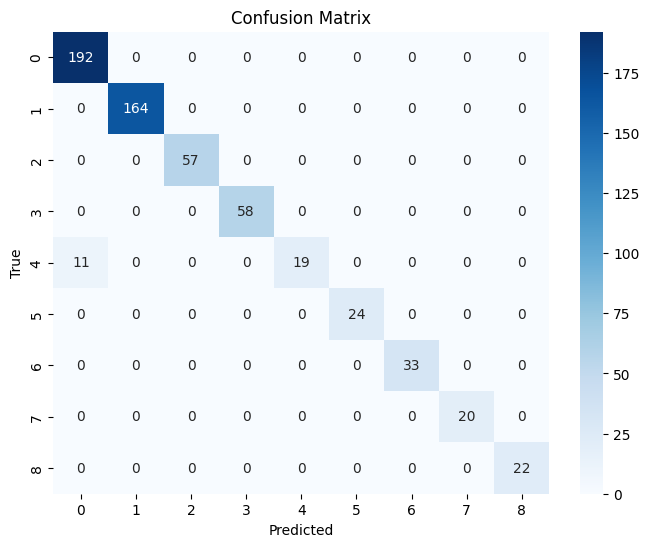

In [68]:
# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

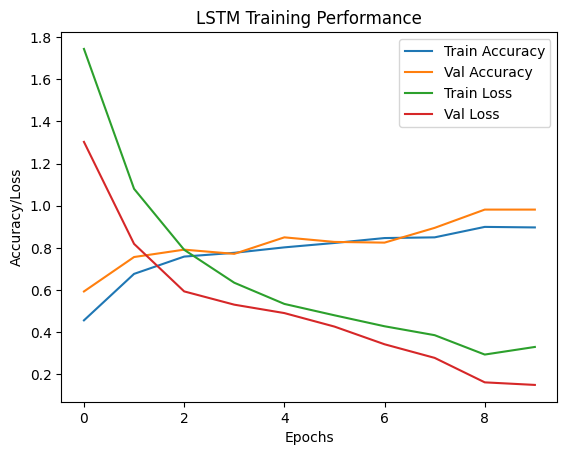

In [69]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.title("LSTM Training Performance")
plt.show()
